<a href="https://colab.research.google.com/github/utkrisht128/ChatApp/blob/main/Food_vision_part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tranfer learning with tensorfow part 1: Feature Extraction

Transfer learning is leaveragin a working model existin architecture and learned patterns for our own problem.

There are two main benefits:
1. Can leverage an existin neural network architecture proven to work on problem similar to our own.
2. Can leverae a workin neural network architecture which has already learned patterns on similar data to our own, then we can adapt those patterns to our own data

### Downloading and becoming one with the data

In [ ]:
# Get data (10% of 10 food classes from Food101)
import zipfile

# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
#Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2023-06-04 05:34:46--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.141.128, 173.194.210.128, 172.253.123.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   122MB/s    in 1.3s    

2023-06-04 05:34:48 (122 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# How many images in each folder
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in `{dirpath}`")

There are 2 directories and 0 images in `10_food_classes_10_percent`
There are 10 directories and 0 images in `10_food_classes_10_percent/train`
There are 0 directories and 75 images in `10_food_classes_10_percent/train/chicken_wings`
There are 0 directories and 75 images in `10_food_classes_10_percent/train/steak`
There are 0 directories and 75 images in `10_food_classes_10_percent/train/ramen`
There are 0 directories and 75 images in `10_food_classes_10_percent/train/grilled_salmon`
There are 0 directories and 75 images in `10_food_classes_10_percent/train/pizza`
There are 0 directories and 75 images in `10_food_classes_10_percent/train/fried_rice`
There are 0 directories and 75 images in `10_food_classes_10_percent/train/chicken_curry`
There are 0 directories and 75 images in `10_food_classes_10_percent/train/hamburger`
There are 0 directories and 75 images in `10_food_classes_10_percent/train/ice_cream`
There are 0 directories and 75 images in `10_food_classes_10_percent/train/sush

### Creating data loaders (preparing the data)
we will use `ImageDataGenerator` class to load in our images in batches

In [ ]:
# Setup data inputs
from keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")

print("Testing images:")
test_data =  test_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilst our model trains)

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks:

* Tracking experiments with the TensorBoard callback
* Model checkpoint with the ModelCheckpoint callback
* Stopping a model from training (before it trains too long and overfits) with the EarlyStopping callback

In [ ]:
import tensorflow as tf

In [ ]:
# Create TensorBoard callback (functionized because we need to create a new one for each model)
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

> **Note:** You can customize the directory where your TensorBoard logs (model training metrics) get saved to whatever you like.     
The `log_dir` parameter we have created above is only one option

## Creating model using Tensorflow Hub

In the past we have used TensorFlow to create our own model layer by layer from scratch.

Now we are going to do a similar process except the majority of our model's layers are going to come from TensorFlow Hub.

We can access pretrained models on:
https://www.tensorflow.org/hub

In [ ]:
# Lets comapre the following two models
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [ ]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from keras import layers

In [ ]:
# Lets make a create model() function to create a model from a URL
def create_model(model_url, num_classes=10):
  """
  Takes a TensorFlow Hub URL and create a keras sequential model with it.

  Args:
   model_url (str) : A TensorFlow Hub feature extraction URL.
   num_classes (int) : Number of output neurons in the output layer,
     should be equal to number of target classes, default 10.

   Return:
    An uncompiled Keras Sequential model with model_url as feature extractor
    layer and Dense output layer with num_classes output neurons.
  """

  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False,  # Freeze already learned pattern
                                           name="feature_extraction_layer",
                                           input_shape=IMAGE_SHAPE+(3,))

  # Create our own model
  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])
  return model

In [ ]:
IMAGE_SHAPE+(3,)

(224, 224, 3)

### Creating and testing ResNet TensorFlow Hub Feature Extraction model

In [ ]:
train_data_10_percent.num_classes

10

In [ ]:
# Create Resnet model
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)

In [ ]:
resnet_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="resnet50V2")])

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20230604-060216
Epoch 1/5
24/24 [==============================] - 25s 1s/step - loss: 0.0283 - accuracy: 1.0000 - val_loss: 0.6368 - val_accuracy: 0.7956
Epoch 2/5
24/24 [==============================] - 24s 1s/step - loss: 0.0270 - accuracy: 1.0000 - val_loss: 0.6374 - val_accuracy: 0.7972
Epoch 3/5
24/24 [==============================] - 24s 1s/step - loss: 0.0257 - accuracy: 1.0000 - val_loss: 0.6409 - val_accuracy: 0.7984
Epoch 4/5
24/24 [==============================] - 24s 1s/step - loss: 0.0244 - accuracy: 1.0000 - val_loss: 0.6426 - val_accuracy: 0.7952
Epoch 5/5
24/24 [==============================] - 25s 1s/step - loss: 0.0231 - accuracy: 1.0000 - val_loss: 0.6448 - val_accuracy: 0.7980


In [ ]:
resnet_model.evaluate(test_data)

79/79 [==============================] - 14s 177ms/step - loss: 0.6448 - accuracy: 0.7980


[0.6447688341140747, 0.7979999780654907]

In [ ]:
import matplotlib.pyplot as plt


# Plot the validation and training curves separately
def plot_loss_curve(history):
  """
  Return separate loss curve for training and validation metrics.
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"])) # How many epochs did we run for?

  # Plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend()

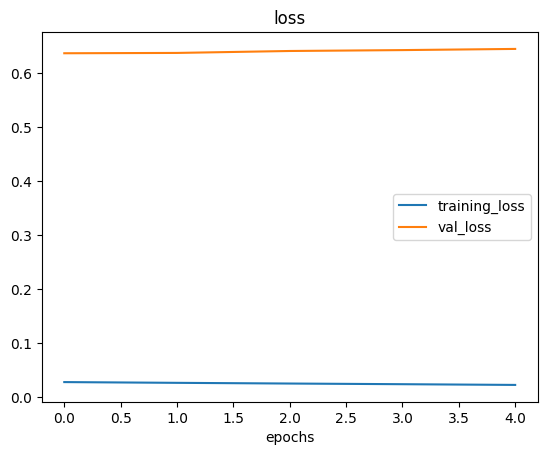

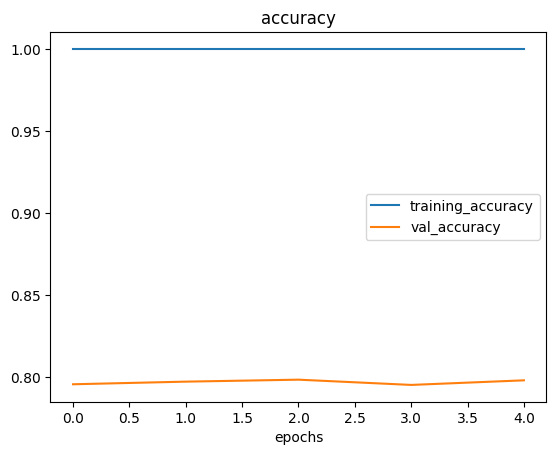

In [ ]:
plot_loss_curve(resnet_history)

In [ ]:
efficientnet_model = create_model(efficientnet_url,
                               num_classes=train_data_10_percent.num_classes)
efficientnet_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics=["accuracy"])

efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                        epochs=5,
                                        steps_per_epoch=len(train_data_10_percent),
                                        validation_data=test_data,
                                        validation_steps=len(test_data),
                                        callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                              experiment_name="efficientnetb0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetb0/20230604-055712
Epoch 1/5
24/24 [==============================] - 29s 805ms/step - loss: 1.8264 - accuracy: 0.4600 - val_loss: 1.2712 - val_accuracy: 0.7564
Epoch 2/5
24/24 [==============================] - 18s 760ms/step - loss: 1.0485 - accuracy: 0.7827 - val_loss: 0.8585 - val_accuracy: 0.8244
Epoch 3/5
24/24 [==============================] - 17s 723ms/step - loss: 0.7506 - accuracy: 0.8333 - val_loss: 0.6944 - val_accuracy: 0.8428
Epoch 4/5
24/24 [==============================] - 26s 1s/step - loss: 0.6026 - accuracy: 0.8733 - val_loss: 0.6084 - val_accuracy: 0.8564
Epoch 5/5
24/24 [==============================] - 18s 763ms/step - loss: 0.5114 - accuracy: 0.8827 - val_loss: 0.5565 - val_accuracy: 0.8580


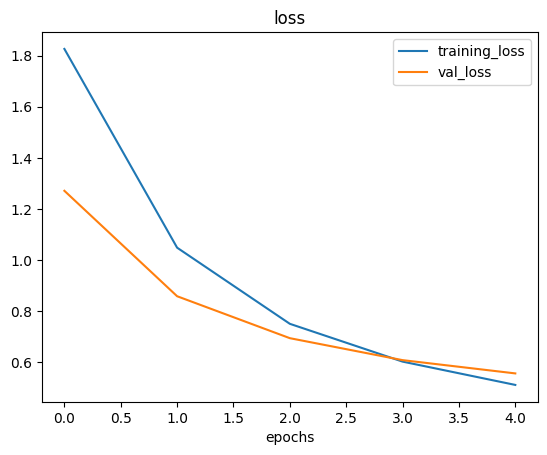

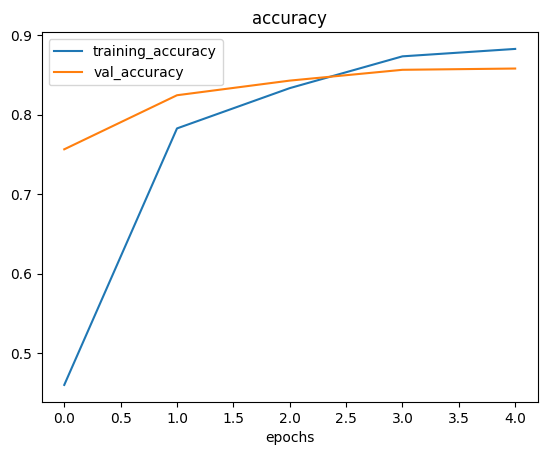

In [ ]:
plot_loss_curve(efficientnet_history)

In [ ]:
efficientnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


## Different types of transfer learning

* **"As is" transfer learning** - using an existing model with no chnages what so ever (eg. using ImageNet model on 1000 ImageNet classes, none of your own)
* **"Feature extraction" transfer learning** - use the prelearned patterns of an existing model (eg. EfficientNetB0 trained on ImageNet) and adjust the output layer for your own problem (eg. 1000 classes -> 10 classes of food)
* **"Fine Tuning" transfer learning** - use the prelearned patterns of an existing model and "fine-tune" many or all of the underlying layers (including new output layers)

## Comparing our models using TensorBoard



> **Note:** When you upload things to TensorBoard.dev, you experiments are public. So if you are running private experiments (things you don't want other to see) do not upload them to TensorBoard.dev





In [ ]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
 --name "EfficientNetB0 vs ResNet50V2" \
 --description "Comparing two different TF Hub feature extraction model architecture using 10 percent of the training data" \
 --one_shot

2023-06-04 06:21:08.594285: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) y

To sign in with the TensorBoard uploader:

1. On your computer or phone, visit:

   https://www.google.com/device

2. Sign in with your Google account, then enter:

   MWXF-MCPX



New experiment created. View your TensorBoard at: https://tensorboard.dev/experi

In [ ]:
!tensorboard dev list

2023-06-04 06:25:05.514656: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
https://tensorboard.dev/experiment/BHxlx3oYQ1Sqpr8uwQqvYw/
	Name                 EfficientNetB0 vs ResNet50V2
	Description          Comparing two different TF Hub feature extraction model architecture using 10 percent of the training data
	Id                   BHxlx3oYQ1Sqpr8uwQqvYw
	Created              2023-06-04 06:22:06 (3 minutes ago)
	Updated              2023-06-04 06:22:11 (2 minutes ago)
	Runs                 10
	Tags                 5
	Scalars              240
	Tensor bytes         0
	Binary object bytes  10989690
Total: 1 experiment(s)
